# Colab Setting

In [ ]:
import os
from google.colab import drive
# mount Google drive
drive.mount('/content/drive')


# by default everything gets executed and saved in 'Berkeley Capstone (Students)'
# notebook_path = '/content/drive/MyDrive/Berkeley Capstone (Students)/Code' # WK
notebook_path = '/content/drive/MyDrive/Capstone/Berkeley Capstone (Students)/Code/InsDetek3.0_LSTM' # GQ
os.chdir(notebook_path)
!echo -e "\nCurrent directory:"
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Current directory:
/content/drive/.shortcut-targets-by-id/1yBERxWlYaZqd2aPZEzBr21t8G6McvwZA/Berkeley Capstone (Students)/Code/InsDetek3.0_LSTM


# Read Data

In [ ]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm, trange
from collections import defaultdict
import matplotlib.pyplot as plt
import time
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import random

In [ ]:
week_df = pd.read_csv('../ExtractedData/weekr4.2.csv')

# Delete Features

In [ ]:

# week_df = week_df.drop(columns = ['week','starttime','endtime', 'A', 'C', 'E', 'ITAdmin', 'N', 'O', 'dept', 'f_unit', 'role', 'team'])
week_df = week_df.drop(columns = ['starttime','endtime', 'A', 'C', 'E', 'ITAdmin', 'N', 'O', 'dept', 'f_unit', 'role', 'team'])
week_df.loc[week_df['insider'].isin([2,3]),'insider'] = 1
week_df['insider'].value_counts()

0    66850
1      316
Name: insider, dtype: int64

In [ ]:
# delete features that has the same value
def del_const_fea(input_df):
    df = input_df
    del_col = set()
    for i in range(df.shape[1]):
        # print(i,df.iloc[:,i])
        if len(df.iloc[:,i].value_counts()) == 1:
            del_col.add(df.columns[i])
    df = df.drop(columns = del_col)
    return df, set(del_col)

# 1. throughout the whole dataset
df_deleted, del_col = del_const_fea(week_df)
df_deleted.shape

(67166, 446)

# Normalization

## on whole dataset

In [ ]:
df_deleted.mean()

user                                    501.559271
week                                     35.391403
n_allact                                487.829646
allact_n-pc0                            485.555966
allact_n-pc1                              0.264628
                                           ...    
weekendhttp_leakf_mean_url_depth          0.000476
weekendhttp_leakf_mean_http_c_len         0.045931
weekendhttp_leakf_mean_http_c_nwords      0.005479
weekendhttp_leakf_n-pc0                   0.000119
insider                                   0.004705
Length: 446, dtype: float64

In [ ]:
# norm on whole dataset
df = df_deleted.copy()
df.iloc[:,1:-1] = df_deleted.iloc[:,1:-1].apply(lambda col: (col-col.mean())/col.std())
df

,user,week,n_allact,allact_n-pc0,allact_n-pc1,allact_n-pc2,allact_n-pc3,n_workhourallact,workhourallact_n-pc0,workhourallact_n-pc1,...,weekendhttp_jobf_mean_http_c_len,weekendhttp_jobf_mean_http_c_nwords,weekendhttp_jobf_n-pc0,weekendhttp_n_leakf,weekendhttp_leakf_mean_url_len,weekendhttp_leakf_mean_url_depth,weekendhttp_leakf_mean_http_c_len,weekendhttp_leakf_mean_http_c_nwords,weekendhttp_leakf_n-pc0,insider
0,0,-1.662642,0.139703,0.147201,-0.261563,-0.119838,-0.022762,0.090730,0.093571,-0.250175,...,-0.127181,-0.127622,-0.080772,-0.010914,-0.010914,-0.010914,-0.010666,-0.010675,-0.010914,0
1,1,-1.662642,1.259297,1.270351,-0.261563,-0.119838,-0.022762,1.444608,1.447985,-0.250175,...,-0.127181,-0.127622,-0.080772,-0.010914,-0.010914,-0.010914,-0.010666,-0.010675,-0.010914,0
2,2,-1.662642,0.356199,0.364385,-0.261563,-0.119838,-0.022762,0.362801,0.365750,-0.250175,...,-0.127181,-0.127622,-0.080772,-0.010914,-0.010914,-0.010914,-0.010666,-0.010675,-0.010914,0
3,3,-1.662642,-1.307728,-1.304827,-0.261563,-0.119838,-0.022762,-1.276103,-1.273803,-0.250175,...,-0.127181,-0.127622,-0.080772,-0.010914,-0.010914,-0.010914,-0.010666,-0.010675,-0.010914,0
4,4,-1.662642,-1.310821,-1.307930,-0.261563,-0.119838,-0.022762,-1.263147,-1.260842,-0.250175,...,-0.127181,-0.127622,-0.080772,-0.010914,-0.010914,-0.010914,-0.010666,-0.010675,-0.010914,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67161,994,1.769832,-1.468553,-1.466164,-0.261563,-0.119838,-0.022762,-1.415377,-1.413133,-0.250175,...,-0.127181,-0.127622,-0.080772,-0.010914,-0.010914,-0.010914,-0.010666,-0.010675,-0.010914,0
67162,995,1.769832,-0.859272,-0.854947,-0.261563,-0.119838,-0.022762,-0.767589,-0.765088,-0.250175,...,-0.127181,-0.127622,-0.080772,-0.010914,-0.010914,-0.010914,-0.010666,-0.010675,-0.010914,0
67163,996,1.769832,-0.958241,-0.954231,-0.261563,-0.119838,-0.022762,-0.871235,-0.868775,-0.250175,...,-0.127181,-0.127622,-0.080772,-0.010914,-0.010914,-0.010914,-0.010666,-0.010675,-0.010914,0
67164,997,1.769832,-0.958241,-0.954231,-0.261563,-0.119838,-0.022762,-0.877713,-0.875256,-0.250175,...,-0.127181,-0.127622,-0.080772,-0.010914,-0.010914,-0.010914,-0.010666,-0.010675,-0.010914,0


In [ ]:
df.to_csv('week_norm_all_withweek.csv')

In [ ]:
df = df.drop(columns = ['week'])
df.to_csv('week_norm_all.csv')

## norm by user

In [ ]:
# norm by user
df = df_deleted.copy()
df_new = pd.DataFrame()
for u in df['user'].value_counts().index:
    df_user = df.loc[df['user']==u].copy()
    for idx, std in df_user.iloc[:,1:-1].std().items():
        if std == 0:
            df_user[idx] = 0 # 常数feature的标准化可以直接全归零吗?
        else:
            df_user[idx] = (df_user[idx]-df_user[idx].mean())/std
    df_new = df_new.append(df_user)
    
df_new

,user,week,n_allact,allact_n-pc0,allact_n-pc1,allact_n-pc2,allact_n-pc3,n_workhourallact,workhourallact_n-pc0,workhourallact_n-pc1,...,weekendhttp_jobf_mean_http_c_len,weekendhttp_jobf_mean_http_c_nwords,weekendhttp_jobf_n-pc0,weekendhttp_n_leakf,weekendhttp_leakf_mean_url_len,weekendhttp_leakf_mean_url_depth,weekendhttp_leakf_mean_http_c_len,weekendhttp_leakf_mean_http_c_nwords,weekendhttp_leakf_n-pc0,insider
0,0,-1.696256,0.340262,0.340262,0.0,0.000000,0.0,0.203358,0.203358,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1000,0,-1.648474,0.280472,0.280472,0.0,0.000000,0.0,0.315741,0.315741,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2000,0,-1.600692,0.325314,0.325314,0.0,0.000000,0.0,0.235468,0.235468,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3000,0,-1.552910,0.355209,0.355209,0.0,0.000000,0.0,0.444178,0.444178,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4000,0,-1.505128,0.370157,0.370157,0.0,0.000000,0.0,0.074922,0.074922,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816,816,-1.264911,-0.717493,-0.430835,0.0,-1.227881,0.0,-0.199724,-0.121069,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1816,816,-0.632456,1.474847,1.331670,0.0,0.526235,0.0,0.387699,0.429246,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2816,816,0.000000,0.478329,0.548335,0.0,-0.350823,0.0,0.387699,0.429246,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3816,816,0.632456,-1.016449,-1.312087,0.0,1.403293,0.0,-1.609539,-1.661952,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
df_new.to_csv('week_norm_by_user.csv')

In [ ]:
df_new.std()

user                                    287.840721
n_allact                                  0.992535
allact_n-pc0                              0.992535
allact_n-pc1                              0.335320
allact_n-pc2                              0.511507
                                           ...    
weekendhttp_leakf_mean_url_depth          0.068374
weekendhttp_leakf_mean_http_c_len         0.068374
weekendhttp_leakf_mean_http_c_nwords      0.068374
weekendhttp_leakf_n-pc0                   0.068374
insider                                   0.068430
Length: 445, dtype: float64

# Split

In [ ]:
df = pd.read_csv('week_norm_all_withweek.csv')

In [ ]:
  def split_dataset(data):
  
    data1stHalf = data[data.week <= max(data.week)/2]
    dataTest = data[data.week > max(data.week)/2]

    selectedTrainUsers =  set(data1stHalf[data1stHalf.insider > 0]['user'])
    nUsers = np.random.permutation(list(set(data1stHalf.user) - selectedTrainUsers))
    trainUsers = np.concatenate((list(selectedTrainUsers), nUsers[:200-len(selectedTrainUsers)]))

    unKnownTestUsers = list(set(dataTest.user) - selectedTrainUsers)
    
    df_Train = data1stHalf[data1stHalf.user.isin(trainUsers)][:]#.values
    # Wenqi: Test dataset not the validation dataset
    df_Test = dataTest[dataTest.user.isin(unKnownTestUsers)][:]#.values
    
    return df_Train, df_Test

In [ ]:
df, df_Test = split_dataset(df)

In [ ]:
df.to_csv('week_norm_all_train.csv')
df_Test.to_csv('week_norm_all_test.csv')

In [ ]:
df.shape

(9762, 447)

In [ ]:
df_Test.shape

(16384, 447)

In [ ]:
df['user'].nunique()

200

In [ ]:
df_Test['user'].nunique()

880

# sth
1. find duplicates  


In [ ]:
user938 = week_df[week_df['user'] == 938].drop_duplicates(keep='first', inplace=False)

2. show distribution per user per feature

In [ ]:
user938.mean().sort_values()

weekendfile_n_txtf                        0.000000
http_otherf_n-pc3                         0.000000
http_socnetf_n-pc1                        0.000000
http_socnetf_n-pc2                        0.000000
http_socnetf_n-pc3                        0.000000
                                          ...     
email_mean_email_text_slen              356.860648
workhouremail_mean_email_text_slen      356.860648
user                                    938.000000
email_mean_email_size                 30045.868287
workhouremail_mean_email_size         30045.868287
Length: 657, dtype: float64

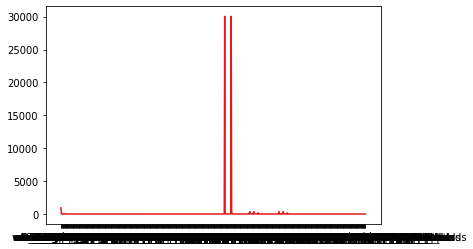

In [ ]:
plt.plot(user938.mean())

insider activities per user

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


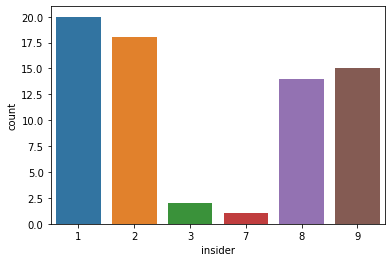

In [ ]:
insider_byuser = week_df.groupby('user')[['insider']].sum().sort_values('insider')
insider_byuser = insider_byuser[insider_byuser['insider']!=0]['insider']
sns.countplot(insider_byuser)

4. constant features per user

In [ ]:
# 2. by user
del_fea = set()
del_feas = {}
del_bar = tqdm(df.groupby('user'), leave = True)
for user, user_df in del_bar: 
    # if 'O' not in temp:
    #     print(user,temp)
    temp = del_const_fea(user_df)[1]
    del_feas[user] = temp
    print('User',user,'find {} constant features'.format(len(temp)))
    if len(del_fea) == 0:
        del_fea = temp
    else:
        del_fea = del_fea.intersection(temp)
del_fea # cols to be dropped in the first cell

  0%|          | 0/1000 [00:00<?, ?it/s]

User 0 find 324 constant features
User 1 find 355 constant features
User 2 find 213 constant features
User 3 find 327 constant features
User 4 find 227 constant features
User 5 find 371 constant features
User 6 find 371 constant features
User 7 find 342 constant features
User 8 find 354 constant features
User 9 find 342 constant features
User 10 find 316 constant features
User 11 find 304 constant features
User 12 find 240 constant features
User 13 find 334 constant features
User 14 find 342 constant features
User 15 find 342 constant features
User 16 find 356 constant features
User 17 find 344 constant features
User 18 find 379 constant features
User 19 find 219 constant features
User 20 find 301 constant features
User 21 find 387 constant features
User 22 find 385 constant features
User 23 find 326 constant features
User 24 find 324 constant features
User 25 find 367 constant features
User 26 find 361 constant features
User 27 find 379 constant features
User 28 find 260 constant feat

{'A', 'C', 'E', 'ITAdmin', 'N', 'O', 'dept', 'f_unit', 'role', 'team', 'user'}

In [ ]:
del_feas_sort = sorted(del_feas.items(), key=lambda item:len(item[1]))
for i in range(len(del_feas)):
    print('User', del_feas_sort[i][0], ':', len(del_feas_sort[i][1]), 'constant features')

User 571 : 122 constant features
User 898 : 122 constant features
User 822 : 123 constant features
User 844 : 125 constant features
User 864 : 125 constant features
User 905 : 125 constant features
User 195 : 126 constant features
User 188 : 132 constant features
User 229 : 141 constant features
User 300 : 141 constant features
User 776 : 143 constant features
User 993 : 145 constant features
User 856 : 149 constant features
User 150 : 150 constant features
User 924 : 152 constant features
User 966 : 152 constant features
User 77 : 155 constant features
User 98 : 155 constant features
User 908 : 156 constant features
User 513 : 157 constant features
User 304 : 158 constant features
User 469 : 158 constant features
User 994 : 160 constant features
User 946 : 162 constant features
User 81 : 164 constant features
User 37 : 166 constant features
User 916 : 166 constant features
User 874 : 167 constant features
User 981 : 167 constant features
User 878 : 169 constant features
User 338 : 170

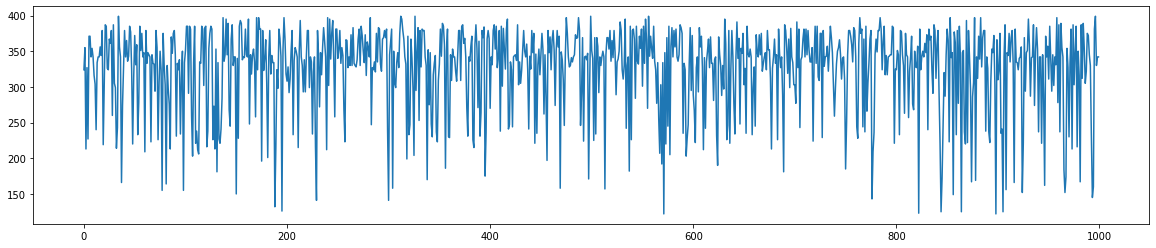

In [ ]:
del_feas_cnt = [len(a) for a in del_feas.values()]
plt.figure(figsize = (20,4))
plt.plot(del_feas_cnt)

# EDA

In [ ]:
df = pd.read_csv('./data/week_norm_all.csv').iloc[:,1:]

In [ ]:
df_ori = pd.read_csv('./data/week.csv').drop(columns=['week']).iloc[:,2:-1]
df_norm = pd.read_csv('./data/week_norm_all.csv').iloc[:,2:-1]

In [ ]:
print(df_ori.shape, '\n', df_norm.shape)

(67166, 443) 
 (67166, 443)


In [ ]:
pd.DataFrame(df_ori.columns)

,0
0,n_allact
1,allact_n-pc0
2,allact_n-pc1
3,allact_n-pc2
4,allact_n-pc3
...,...
438,weekendhttp_leakf_mean_url_len
439,weekendhttp_leakf_mean_url_depth
440,weekendhttp_leakf_mean_http_c_len
441,weekendhttp_leakf_mean_http_c_nwords


## Statistical tests

In [ ]:
df_norm.astype('double')

,n_allact,allact_n-pc0,allact_n-pc1,allact_n-pc2,allact_n-pc3,n_workhourallact,workhourallact_n-pc0,workhourallact_n-pc1,workhourallact_n-pc2,workhourallact_n-pc3,...,weekendhttp_jobf_mean_url_depth,weekendhttp_jobf_mean_http_c_len,weekendhttp_jobf_mean_http_c_nwords,weekendhttp_jobf_n-pc0,weekendhttp_n_leakf,weekendhttp_leakf_mean_url_len,weekendhttp_leakf_mean_url_depth,weekendhttp_leakf_mean_http_c_len,weekendhttp_leakf_mean_http_c_nwords,weekendhttp_leakf_n-pc0
0,0.139703,0.147201,-0.261563,-0.119838,-0.022762,0.090730,0.093571,-0.250175,-0.049833,-0.00825,...,-0.115949,-0.127181,-0.127622,-0.080772,-0.010914,-0.010914,-0.010914,-0.010666,-0.010675,-0.010914
1,1.259297,1.270351,-0.261563,-0.119838,-0.022762,1.444608,1.447985,-0.250175,-0.049833,-0.00825,...,-0.115949,-0.127181,-0.127622,-0.080772,-0.010914,-0.010914,-0.010914,-0.010666,-0.010675,-0.010914
2,0.356199,0.364385,-0.261563,-0.119838,-0.022762,0.362801,0.365750,-0.250175,-0.049833,-0.00825,...,-0.115949,-0.127181,-0.127622,-0.080772,-0.010914,-0.010914,-0.010914,-0.010666,-0.010675,-0.010914
3,-1.307728,-1.304827,-0.261563,-0.119838,-0.022762,-1.276103,-1.273803,-0.250175,-0.049833,-0.00825,...,-0.115949,-0.127181,-0.127622,-0.080772,-0.010914,-0.010914,-0.010914,-0.010666,-0.010675,-0.010914
4,-1.310821,-1.307930,-0.261563,-0.119838,-0.022762,-1.263147,-1.260842,-0.250175,-0.049833,-0.00825,...,-0.115949,-0.127181,-0.127622,-0.080772,-0.010914,-0.010914,-0.010914,-0.010666,-0.010675,-0.010914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67161,-1.468553,-1.466164,-0.261563,-0.119838,-0.022762,-1.415377,-1.413133,-0.250175,-0.049833,-0.00825,...,-0.115949,-0.127181,-0.127622,-0.080772,-0.010914,-0.010914,-0.010914,-0.010666,-0.010675,-0.010914
67162,-0.859272,-0.854947,-0.261563,-0.119838,-0.022762,-0.767589,-0.765088,-0.250175,-0.049833,-0.00825,...,-0.115949,-0.127181,-0.127622,-0.080772,-0.010914,-0.010914,-0.010914,-0.010666,-0.010675,-0.010914
67163,-0.958241,-0.954231,-0.261563,-0.119838,-0.022762,-0.871235,-0.868775,-0.250175,-0.049833,-0.00825,...,-0.115949,-0.127181,-0.127622,-0.080772,-0.010914,-0.010914,-0.010914,-0.010666,-0.010675,-0.010914
67164,-0.958241,-0.954231,-0.261563,-0.119838,-0.022762,-0.877713,-0.875256,-0.250175,-0.049833,-0.00825,...,-0.115949,-0.127181,-0.127622,-0.080772,-0.010914,-0.010914,-0.010914,-0.010666,-0.010675,-0.010914


In [ ]:
!pip install factor_analyzer

In [ ]:
#充分性检测
print('巴特利球形度检验')
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(df_norm)
print('卡方值：',chi_square_value,'P值', p_value)

#相关性检验kmo要大于0.6
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(df_norm)
print('KMO检验：',kmo_model)

巴特利球形度检验


/usr/local/lib/python3.7/dist-packages/factor_analyzer/factor_analyzer.py:111: RuntimeWarning: divide by zero encountered in log
  statistic = -np.log(corr_det) * (n - 1 - (2 * p + 5) / 6)


卡方值： inf P值 0.0


/usr/local/lib/python3.7/dist-packages/factor_analyzer/utils.py:249: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


KMO检验： 0.5460168953326597


## Corr

Normalization doesn't change correlationship

In [ ]:
corr = df_norm.corr()

In [ ]:
from IPython.core.pylabtools import figsize
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Heatmap(z = np.array(corr), x = corr.columns, y = corr.columns))
fig.update_layout(autosize=False, width=1000, height=1000)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import seaborn as sns
plt.figure(figsize=(15, 10))
sns.heatmap(df_norm.corr()) 

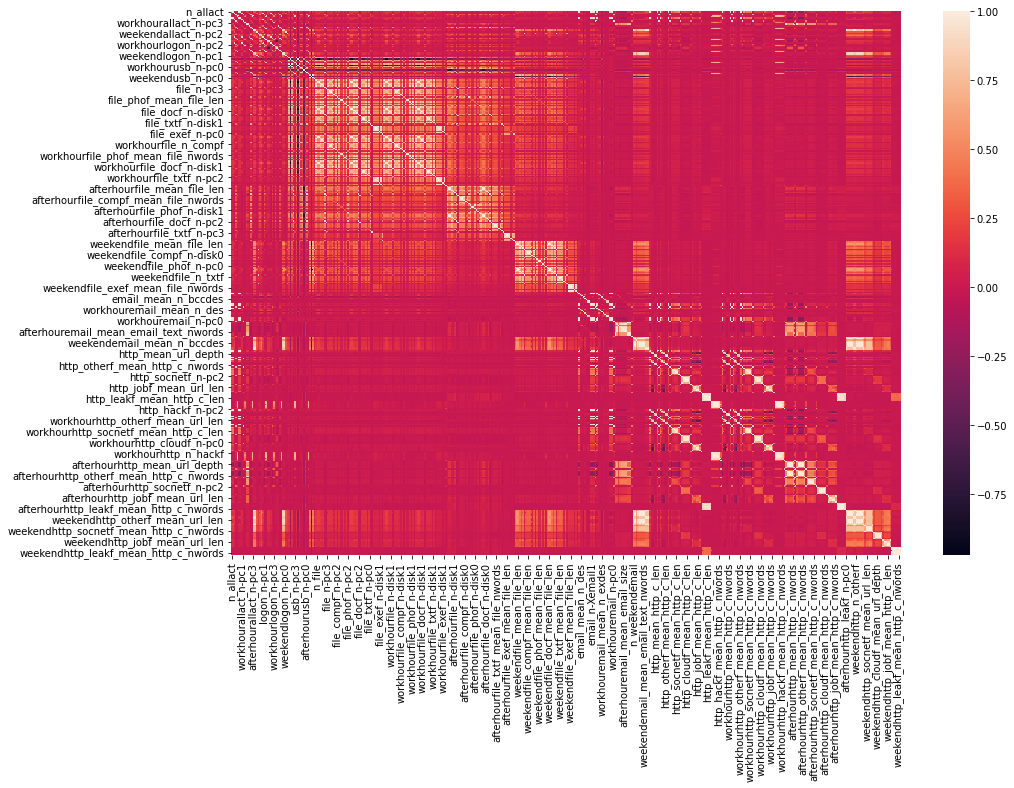

## Sparse

In [ ]:
df_ori

,n_allact,allact_n-pc0,allact_n-pc1,allact_n-pc2,allact_n-pc3,n_workhourallact,workhourallact_n-pc0,workhourallact_n-pc1,workhourallact_n-pc2,workhourallact_n-pc3,...,weekendhttp_jobf_mean_url_depth,weekendhttp_jobf_mean_http_c_len,weekendhttp_jobf_mean_http_c_nwords,weekendhttp_jobf_n-pc0,weekendhttp_n_leakf,weekendhttp_leakf_mean_url_len,weekendhttp_leakf_mean_url_depth,weekendhttp_leakf_mean_http_c_len,weekendhttp_leakf_mean_http_c_nwords,weekendhttp_leakf_n-pc0
0,533,533,0,0,0,475,475,0,0,0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0
1,895,895,0,0,0,893,893,0,0,0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0
2,603,603,0,0,0,559,559,0,0,0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0
3,65,65,0,0,0,53,53,0,0,0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0
4,64,64,0,0,0,57,57,0,0,0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67161,13,13,0,0,0,10,10,0,0,0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0
67162,210,210,0,0,0,210,210,0,0,0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0
67163,178,178,0,0,0,178,178,0,0,0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0
67164,178,178,0,0,0,176,176,0,0,0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0


In [ ]:
plt.figure(figsize = (20,10))
count_zero = df_ori.apply(lambda x: x.value_counts().get(0)).sort_values()
x = np.array(range(443))
y = count_zero.values
plt.plot(x, y)
plt.xlabel("445 features")
plt.ylabel('count zero')
plt.title('Sparse Features')

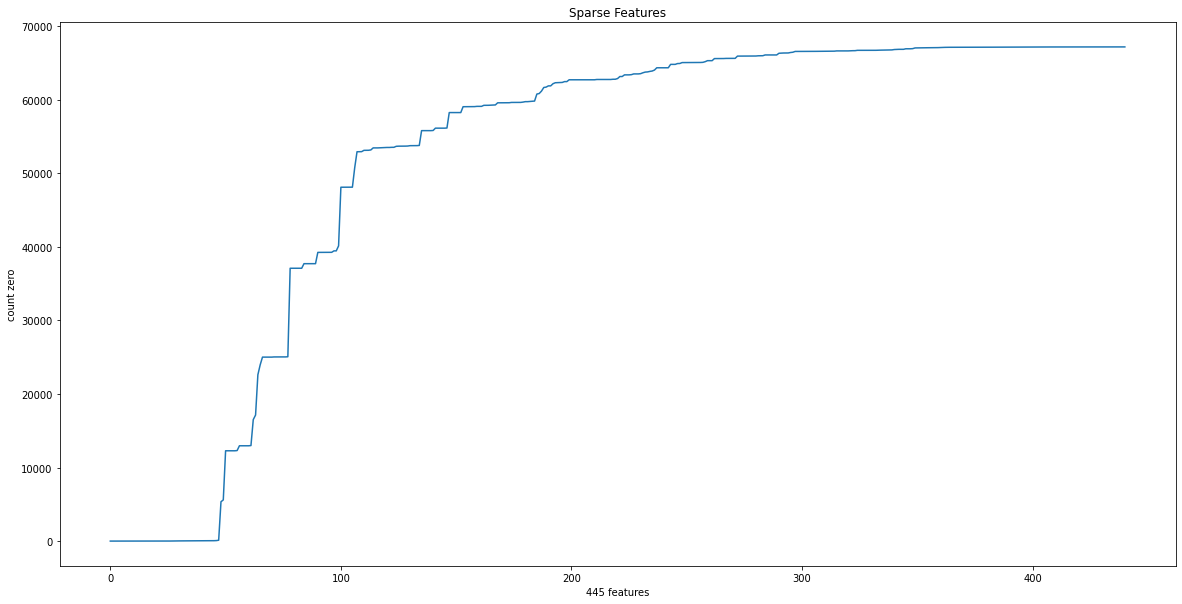

In [ ]:
import plotly.express as px
px.line(y)

## insider distribution

In [ ]:
def ins_dist(df, pic = True):
    ins = pd.DataFrame()
    ins['insider_counts']= pd.DataFrame(df[['user', 'insider']].groupby('user').sum())
    ins['len'] = pd.DataFrame(df[['user', 'insider']].groupby('user').count())
    ins.sort_values('insider_counts', ascending = False)
    if pic:
        sns.jointplot(ins['len'], ins['insider_counts'], data=None, kind='scatter', marginal_kws=dict(bins=72, fill=True))
    return ins

before deleting (72,0)

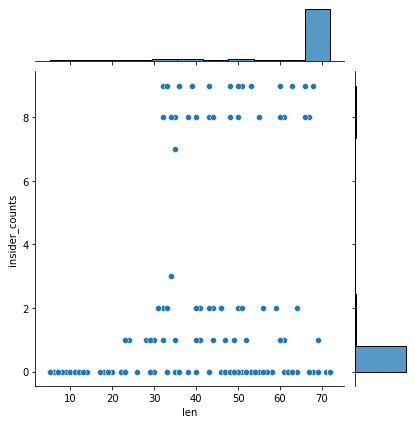

## user-week scatter

In [ ]:
def user_week_plot(df_input, width=None, height=None):
    df = df_input.copy()
    df['insider'] = df['insider'].astype(str)
    user_list = sorted(list(df['user'].unique()))
    df['users (reset idx)'] = df['user'].apply(lambda x: user_list.index(x))

    c = ['rgb(102, 197, 204)', 'rgb(237, 100, 90)']
    fig = px.scatter(df, x='week', y='users (reset idx)', hover_name='user',
            color = 'insider', color_discrete_sequence=c, width=width, height = height)
    fig.update_traces(marker_size = 3)
    # fig = px.scatter(df, x = 'week', , color = 'insider',
    #                 # width=700, height=max(300, n*4),
    #                 color_discrete_sequence=['rgb(102, 197, 204)', 'rgb(237, 100, 90)'])
    fig.show()

In [ ]:
user_week_plot(df_week)

# == PCA ==

In [ ]:
from sklearn.decomposition import PCA
n_components = 170
pca = PCA(n_components) # 直接与变量个数相同的主成分
pca.fit(df_norm)

PCA(n_components=200)

**Deleted 'user' col, otherwise user can be the factor to explain nearly 100%**

In [ ]:
pca_var = pca.explained_variance_ratio_
pca_var[:10]

array([0.13774598, 0.07372026, 0.05643508, 0.0486465 , 0.04628783,
       0.03603323, 0.02889021, 0.02733964, 0.02668126, 0.02595312])

<BarContainer object of 200 artists>

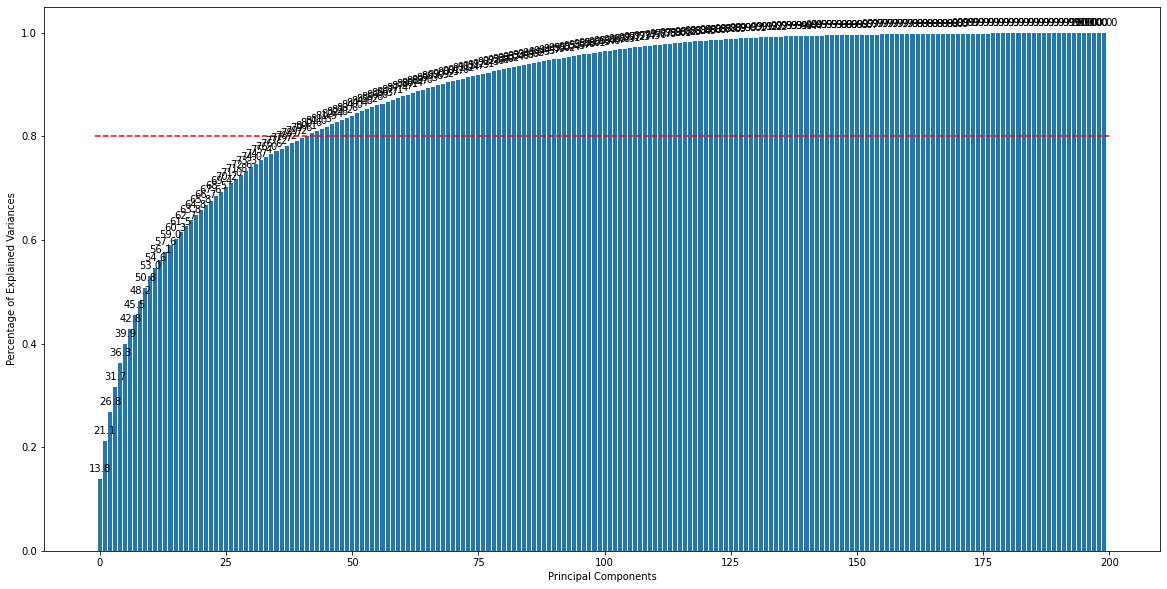

In [ ]:
x = np.arange(n_components)
y = np.cumsum(pca_var)
plt.figure(figsize = (20,10))
for a, b in zip(x, y):
    plt.text(a, b + 0.01, '%.1f' % (b*100), ha='center', va='bottom', fontsize=10)
plt.hlines(0.8, -1, n_components ,color="red", linestyles = '--')#横线
plt.xlabel('Principal Components')
plt.ylabel('Percentage of Explained Variances')
plt.bar(x,y)

In [ ]:
px.bar(y)

In [ ]:
weights = pd.DataFrame(pca.components_[0:180], columns = df_norm.columns, index = ['Factor '+str(i) for i in range(180)]) # 99.8966%
weights

,n_allact,allact_n-pc0,allact_n-pc1,allact_n-pc2,allact_n-pc3,n_workhourallact,workhourallact_n-pc0,workhourallact_n-pc1,workhourallact_n-pc2,workhourallact_n-pc3,...,weekendhttp_jobf_mean_url_depth,weekendhttp_jobf_mean_http_c_len,weekendhttp_jobf_mean_http_c_nwords,weekendhttp_jobf_n-pc0,weekendhttp_n_leakf,weekendhttp_leakf_mean_url_len,weekendhttp_leakf_mean_url_depth,weekendhttp_leakf_mean_http_c_len,weekendhttp_leakf_mean_http_c_nwords,weekendhttp_leakf_n-pc0
Factor 0,0.041193,0.040126,0.017419,0.021964,0.006679,0.029929,0.029721,0.014054,0.004290,0.001265,...,0.036348,0.036564,0.037211,0.038356,0.001289,0.001289,0.001289,0.001345,0.001354,0.001289
Factor 1,-0.040855,-0.042684,-0.024741,0.034142,0.012343,-0.025701,-0.026038,-0.017521,0.009037,0.003570,...,-0.071097,-0.074476,-0.075258,-0.057233,0.000387,0.000387,0.000387,0.000519,0.000514,0.000387
Factor 2,0.174384,0.173516,-0.004468,0.027566,0.011350,0.182818,0.182506,0.001106,0.009119,0.004483,...,-0.014477,-0.017133,-0.017033,-0.008762,-0.002684,-0.002684,-0.002684,-0.002734,-0.002709,-0.002684
Factor 3,-0.021998,-0.024874,-0.001973,0.054012,0.021461,-0.004476,-0.005287,-0.000359,0.019426,0.007500,...,-0.008717,-0.005694,-0.006288,-0.009183,-0.001866,-0.001866,-0.001866,-0.001850,-0.001901,-0.001866
Factor 4,-0.010316,-0.015642,-0.003526,0.101732,0.061968,-0.027548,-0.029188,-0.007827,0.039556,0.025864,...,0.022960,0.024359,0.024566,0.009562,0.008313,0.008313,0.008313,0.008338,0.008369,0.008313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Factor 175,0.005753,0.005739,-0.003688,0.000852,-0.000218,0.004853,0.005403,-0.181015,-0.000580,0.008286,...,-0.001299,0.000152,0.002852,-0.001201,0.000778,0.000778,0.000778,-0.004155,-0.003454,0.000778
Factor 176,0.003281,0.003312,-0.000198,-0.000404,0.000698,0.003498,0.003461,0.006473,0.000512,-0.019533,...,-0.005362,0.002535,0.000624,-0.000435,0.000432,0.000432,0.000432,-0.001281,-0.001331,0.000432
Factor 177,0.009232,0.009297,0.000029,-0.000686,-0.000176,0.007633,0.007556,0.031937,-0.000307,0.008416,...,0.007998,-0.004954,-0.001662,-0.001758,-0.001735,-0.001735,-0.001735,0.009621,0.008126,-0.001735
Factor 178,-0.000185,-0.000190,0.000465,0.000053,0.000221,0.004005,0.004010,-0.002091,0.000070,-0.006717,...,-0.010630,0.006053,0.004554,-0.004277,0.000442,0.000442,0.000442,-0.000619,-0.000927,0.000442


In [ ]:
df_norm.shape

(67166, 443)

In [ ]:
weights.shape

(180, 443)

In [ ]:
df_pca = pd.DataFrame(np.dot(df_norm, weights.T), columns = weights.index)
df_pca['insider'] = df['insider']
df_pca = pd.concat([df['user'], df_pca], axis=1)
df_pca.head()

,user,Factor 0,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,...,Factor 171,Factor 172,Factor 173,Factor 174,Factor 175,Factor 176,Factor 177,Factor 178,Factor 179,insider
0,0,-2.432778,-0.772608,1.244640,-6.722273,2.364647,-0.033157,5.997859,-1.987016,2.315700,...,0.045144,0.140020,-0.064089,-0.191925,-0.081954,0.011343,-0.006972,-0.040413,-0.022907,0
1,1,-2.492286,-1.084984,6.267919,4.167719,-2.066914,-0.220748,1.642403,-0.062249,0.924333,...,-0.022609,0.104669,-0.046801,0.036162,-0.036226,-0.045672,-0.235816,0.064293,0.014389,0
2,2,8.464525,3.934041,1.670582,-7.300089,-3.793170,1.040266,4.828272,-0.184373,-0.912446,...,0.038541,0.142072,-0.077242,-0.142321,-0.056804,0.020836,0.093211,0.015335,-0.057364,0
3,3,-4.189712,1.480616,-7.292713,2.557889,0.086061,0.068121,0.336014,-0.556346,0.821270,...,0.007996,-0.012799,0.015569,-0.008300,-0.010075,0.007826,0.020846,0.082090,-0.059873,0
4,4,-4.161102,1.560044,-8.124948,0.467998,1.072310,-0.006214,0.899081,-1.062198,1.233125,...,-0.032603,0.006035,0.034914,-0.010609,0.079723,0.038385,0.193146,0.062444,-0.292322,0


In [ ]:
px.line(df_pca.iloc[:,:-1].mean())

In [ ]:
px.line(df_pca.iloc[:,:-1].std())

In [ ]:
df_pca.to_csv('data/week_norm_pca.csv', index = False)

In [ ]:
df_pca = pd.read_csv('data/week_norm_pca.csv')

In [ ]:
df_pca

,user,Factor 0,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,...,Factor 171,Factor 172,Factor 173,Factor 174,Factor 175,Factor 176,Factor 177,Factor 178,Factor 179,insider
0,0,-2.432778,-0.772608,1.244640,-6.722273,2.364647,-0.033157,5.997859,-1.987016,2.315700,...,0.045144,0.140020,-0.064089,-0.191925,-0.081954,0.011343,-0.006972,-0.040413,-0.022907,0
1,1,-2.492286,-1.084984,6.267919,4.167719,-2.066914,-0.220748,1.642403,-0.062249,0.924333,...,-0.022609,0.104669,-0.046801,0.036162,-0.036226,-0.045672,-0.235816,0.064293,0.014389,0
2,2,8.464525,3.934041,1.670582,-7.300089,-3.793170,1.040266,4.828272,-0.184373,-0.912446,...,0.038541,0.142072,-0.077242,-0.142321,-0.056804,0.020836,0.093211,0.015335,-0.057364,0
3,3,-4.189712,1.480616,-7.292713,2.557889,0.086061,0.068121,0.336014,-0.556346,0.821270,...,0.007996,-0.012799,0.015569,-0.008300,-0.010075,0.007826,0.020846,0.082090,-0.059873,0
4,4,-4.161102,1.560044,-8.124948,0.467998,1.072310,-0.006214,0.899081,-1.062198,1.233125,...,-0.032603,0.006035,0.034914,-0.010609,0.079723,0.038385,0.193146,0.062444,-0.292322,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67161,994,-4.432749,1.641149,-7.783743,3.096069,-0.209034,0.040160,0.642085,-0.721268,1.153929,...,0.042538,-0.069034,0.007776,0.000213,-0.059497,-0.019183,-0.039851,-0.051423,0.173581,0
67162,995,-4.321563,1.054498,-4.272569,5.093329,-1.362949,-0.022732,0.440544,-0.660168,1.432882,...,-0.016840,0.033663,-0.009912,0.012285,-0.000449,0.009648,0.032192,0.054970,-0.081037,0
67163,996,-4.005589,0.816006,-2.034098,4.502245,-1.319530,-0.050043,1.137651,-0.727005,1.537456,...,-0.005291,0.002047,0.008798,0.006298,0.004887,0.008606,0.043182,0.077573,-0.080448,0
67164,997,-3.778793,0.982504,-3.244526,1.697928,-0.435419,0.114102,-2.750716,-0.392496,0.311461,...,0.009090,-0.002768,0.010892,0.018379,-0.030642,-0.016170,-0.080444,-0.054681,0.061726,0


In [ ]:
pca.transform(df_norm)
# damn...

array([[-2.43277827e+00, -7.72607870e-01,  1.24464016e+00, ...,
        -2.25262939e-03, -8.70223160e-03,  1.27558542e-02],
       [-2.49228626e+00, -1.08498450e+00,  6.26791940e+00, ...,
        -3.01532296e-03, -8.58177373e-03, -2.18994392e-03],
       [ 8.46452519e+00,  3.93404069e+00,  1.67058199e+00, ...,
        -9.64143439e-03,  3.17762741e-02, -1.34511070e-02],
       ...,
       [-4.00558910e+00,  8.16005873e-01, -2.03409755e+00, ...,
         3.20391661e-03,  2.82465142e-03, -4.32839072e-03],
       [-3.77879276e+00,  9.82504148e-01, -3.24452645e+00, ...,
         5.17226992e-03,  6.00300955e-03, -6.36061188e-03],
       [-4.18598737e+00,  1.45475438e+00, -5.42999166e+00, ...,
        -6.68409894e-03,  7.29181399e-03,  1.26679690e-03]])

# == OverSampling ==

In [ ]:
df_samp = df_pca

In [ ]:
ins = pd.DataFrame()
ins['insider_counts']= pd.DataFrame(df_samp[['user', 'insider']].groupby('user').sum())
ins['len'] = pd.DataFrame(df_samp[['user', 'insider']].groupby('user').count())
ins.sort_values('insider_counts', ascending = False)

,insider_counts,len
user,,
831,9,66
492,9,32
539,9,48
419,9,39
347,9,53
...,...,...
351,0,72
352,0,72
353,0,72


In [ ]:
ins_0 = ins[ins['insider_counts'] == 0]
ins_0_72 = ins_0[ins_0['len'] == 72]
clean_list = list(ins_0_72.index)
len(clean_list)

845

**TO DO - Reduce Clean Users**  

---


DBSCAN/KMeans  
delete similar users, extract about 10% of the clean users

---


AE + cos similarity
time series → small vector → similarity

---

Lp Euclidean distance  
Pearson correlation coefficient
DTW Dynamic Time Warping

## 1. Just deleted 70%

In [ ]:
import random
random.shuffle(clean_list)
len_70 = int(len(clean_list)*0.7)
del_clean_list = clean_list[0:len_70]
len(del_clean_list)

591

In [ ]:
df_sampled = df_samp[~df_samp['user'].isin(del_clean_list)]
df_sampled

,user,Factor 0,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,...,Factor 171,Factor 172,Factor 173,Factor 174,Factor 175,Factor 176,Factor 177,Factor 178,Factor 179,insider
1,1,-2.492286,-1.084984,6.267919,4.167719,-2.066914,-0.220748,1.642403,-0.062249,0.924333,...,-0.022609,0.104669,-0.046801,0.036162,-0.036226,-0.045672,-0.235816,0.064293,0.014389,0
2,2,8.464525,3.934041,1.670582,-7.300089,-3.793170,1.040266,4.828272,-0.184373,-0.912446,...,0.038541,0.142072,-0.077242,-0.142321,-0.056804,0.020836,0.093211,0.015335,-0.057364,0
4,4,-4.161102,1.560044,-8.124948,0.467998,1.072310,-0.006214,0.899081,-1.062198,1.233125,...,-0.032603,0.006035,0.034914,-0.010609,0.079723,0.038385,0.193146,0.062444,-0.292322,0
8,8,-2.879962,-0.340867,2.530186,1.994695,-0.845981,-0.127566,1.162044,-0.381275,0.990855,...,0.000876,0.002532,0.025182,0.002054,0.006659,0.010291,0.052660,0.003485,-0.048241,0
10,10,2.992261,-11.999687,-6.656647,1.951321,5.062352,-1.027419,4.884399,3.059450,-4.818825,...,-0.005464,-0.041637,0.008864,0.001174,-0.073468,0.011298,0.011435,0.295134,-0.281012,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67154,987,-3.792380,1.235415,-4.773543,0.841284,-0.161767,0.217436,-6.099723,-0.095341,-0.618251,...,-0.007115,0.009943,0.008432,0.009422,0.008325,-0.009191,-0.018809,-0.068427,0.129573,0
67155,988,-3.900725,0.798739,-2.266876,4.544912,-1.289171,-0.046410,1.343876,-0.583034,1.307098,...,0.014478,-0.041849,0.019598,-0.002663,-0.009579,-0.005818,-0.008072,0.000227,0.035691,0
67156,989,-4.468478,1.669323,-7.764257,2.547646,0.003318,0.119700,0.047206,-0.800538,1.172573,...,-0.012846,0.054522,-0.011438,0.013922,-0.018140,0.017751,0.029286,0.009180,-0.151592,0
67161,994,-4.432749,1.641149,-7.783743,3.096069,-0.209034,0.040160,0.642085,-0.721268,1.153929,...,0.042538,-0.069034,0.007776,0.000213,-0.059497,-0.019183,-0.039851,-0.051423,0.173581,0


In [ ]:
ins = pd.DataFrame()
ins['insider_counts']= pd.DataFrame(df_sampled[['user', 'insider']].groupby('user').sum())
ins['len'] = pd.DataFrame(df_sampled[['user', 'insider']].groupby('user').count())
ins.sort_values('insider_counts', ascending = False)

,insider_counts,len
user,,
492,9,32
539,9,48
623,9,33
206,9,36
422,9,60
...,...,...
380,0,72
378,0,72
376,0,72


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



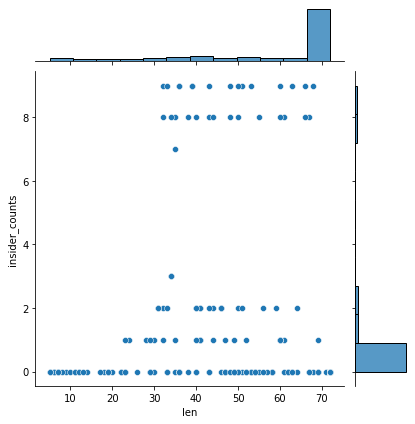

In [ ]:
sns.jointplot(ins['len'], ins['insider_counts'], data=None, kind='scatter')

In [ ]:
df_sampled.to_csv('week_norm_pca_70.csv', index = False)

In [ ]:
pd.read_csv('week_norm_pca_70.csv')

,user,Factor 0,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,...,Factor 171,Factor 172,Factor 173,Factor 174,Factor 175,Factor 176,Factor 177,Factor 178,Factor 179,insider
0,1,-2.492286,-1.084984,6.267919,4.167719,-2.066914,-0.220748,1.642403,-0.062249,0.924333,...,-0.022609,0.104669,-0.046801,0.036162,-0.036226,-0.045672,-0.235816,0.064293,0.014389,0
1,2,8.464525,3.934041,1.670582,-7.300089,-3.793170,1.040266,4.828272,-0.184373,-0.912446,...,0.038541,0.142072,-0.077242,-0.142321,-0.056804,0.020836,0.093211,0.015335,-0.057364,0
2,4,-4.161102,1.560044,-8.124948,0.467998,1.072310,-0.006214,0.899081,-1.062198,1.233125,...,-0.032603,0.006035,0.034914,-0.010609,0.079723,0.038385,0.193146,0.062444,-0.292322,0
3,8,-2.879962,-0.340867,2.530186,1.994695,-0.845981,-0.127566,1.162044,-0.381275,0.990855,...,0.000876,0.002532,0.025182,0.002054,0.006659,0.010291,0.052660,0.003485,-0.048241,0
4,10,2.992261,-11.999687,-6.656647,1.951321,5.062352,-1.027419,4.884399,3.059450,-4.818825,...,-0.005464,-0.041637,0.008864,0.001174,-0.073468,0.011298,0.011435,0.295134,-0.281012,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24609,987,-3.792380,1.235415,-4.773543,0.841284,-0.161767,0.217436,-6.099723,-0.095341,-0.618251,...,-0.007115,0.009943,0.008432,0.009422,0.008325,-0.009191,-0.018809,-0.068427,0.129573,0
24610,988,-3.900725,0.798739,-2.266876,4.544912,-1.289171,-0.046410,1.343876,-0.583034,1.307098,...,0.014478,-0.041849,0.019598,-0.002663,-0.009579,-0.005818,-0.008072,0.000227,0.035691,0
24611,989,-4.468478,1.669323,-7.764257,2.547646,0.003318,0.119700,0.047206,-0.800538,1.172573,...,-0.012846,0.054522,-0.011438,0.013922,-0.018140,0.017751,0.029286,0.009180,-0.151592,0
24612,994,-4.432749,1.641149,-7.783743,3.096069,-0.209034,0.040160,0.642085,-0.721268,1.153929,...,0.042538,-0.069034,0.007776,0.000213,-0.059497,-0.019183,-0.039851,-0.051423,0.173581,0


# == Data Augmentation ==

## delete (72, 0) & len < 15

In [ ]:
df = pd.read_csv('data/week_norm_pca.csv')
print(df.shape)
print(df['user'].unique().shape)
df.head(5)

(67166, 182)
(1000,)


,user,Factor 0,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,...,Factor 171,Factor 172,Factor 173,Factor 174,Factor 175,Factor 176,Factor 177,Factor 178,Factor 179,insider
0,0,-2.432778,-0.772608,1.244640,-6.722273,2.364647,-0.033157,5.997859,-1.987016,2.315700,...,0.045144,0.140020,-0.064089,-0.191925,-0.081954,0.011343,-0.006972,-0.040413,-0.022907,0
1,1,-2.492286,-1.084984,6.267919,4.167719,-2.066914,-0.220748,1.642403,-0.062249,0.924333,...,-0.022609,0.104669,-0.046801,0.036162,-0.036226,-0.045672,-0.235816,0.064293,0.014389,0
2,2,8.464525,3.934041,1.670582,-7.300089,-3.793170,1.040266,4.828272,-0.184373,-0.912446,...,0.038541,0.142072,-0.077242,-0.142321,-0.056804,0.020836,0.093211,0.015335,-0.057364,0
3,3,-4.189712,1.480616,-7.292713,2.557889,0.086061,0.068121,0.336014,-0.556346,0.821270,...,0.007996,-0.012799,0.015569,-0.008300,-0.010075,0.007826,0.020846,0.082090,-0.059873,0
4,4,-4.161102,1.560044,-8.124948,0.467998,1.072310,-0.006214,0.899081,-1.062198,1.233125,...,-0.032603,0.006035,0.034914,-0.010609,0.079723,0.038385,0.193146,0.062444,-0.292322,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


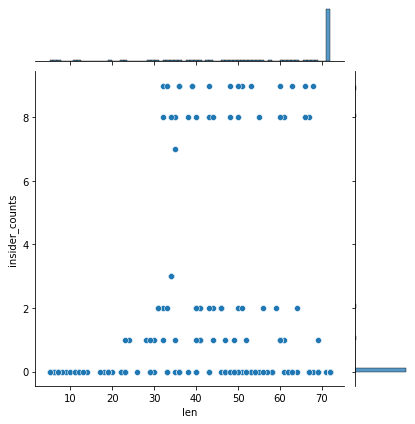

In [ ]:
ins_df = ins_dist(df)

In [ ]:
ins_0_not72 = ins_df[(ins_df['insider_counts'] == 0)&(ins_df['len'] != 72)]
px.histogram(ins_0_not72, x = 'len', nbins = 72)

delete len < 15

In [ ]:
# ins_df[ins_df['len'] == 72] # 845 users with (72, 0)
# ins_df[(ins_df['insider_counts'] == 0)&(ins_df['len'] != 72)] # 85 users with (not 72, 0)
# ins_df[(ins_df['insider_counts'] == 0)&(ins_df['len'] < 15)].shape # 19 users with (<15, 0)
user_del = list(ins_df[(ins_df['len'] == 72)|(ins_df['len'] < 15)].index)

In [ ]:
len(user_del)

864

In [ ]:
# df1: deleted (72,0)
df1 = df[~df['user'].isin(user_del)]
df1['user'].unique().shape

(136,)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



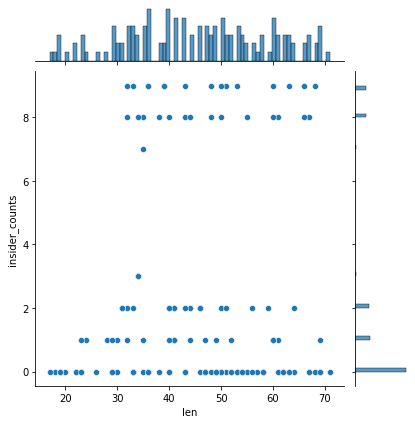

In [ ]:
_ = ins_dist(df1)

In [ ]:
df1.head()

,user,Factor 0,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,...,Factor 171,Factor 172,Factor 173,Factor 174,Factor 175,Factor 176,Factor 177,Factor 178,Factor 179,insider
4,4,-4.161102,1.560044,-8.124948,0.467998,1.072310,-0.006214,0.899081,-1.062198,1.233125,...,-0.032603,0.006035,0.034914,-0.010609,0.079723,0.038385,0.193146,0.062444,-0.292322,0
11,11,-2.305500,0.250883,4.365914,4.736438,0.584315,-0.197276,-1.674050,-0.595670,0.674753,...,-0.017641,-0.003251,0.000009,-0.032265,0.037638,0.026005,0.053618,0.022785,0.023486,0
14,14,-2.181643,0.481197,3.060185,2.956854,2.189645,-0.152925,2.020173,-1.399258,1.919320,...,-0.014198,0.036104,0.001630,0.006455,0.012434,0.005283,0.042302,0.046378,-0.054852,0
19,19,13.541925,-24.209347,2.363907,0.518283,6.316195,-1.686172,7.008737,6.616558,-10.033314,...,0.259808,-0.550333,0.146239,-0.040161,-0.070022,0.012893,0.110709,-0.105692,0.009383,0
26,26,-2.959503,-0.201772,2.386731,3.505731,-1.527463,-0.075507,-1.938480,0.108575,0.026511,...,0.002487,0.040563,-0.021064,0.019389,-0.019802,-0.033703,-0.147209,0.006421,0.075799,0


In [ ]:
df1.to_csv('data/data_1.0.csv', index = True, index_label='idx')

## augmentation: slide window

In [ ]:
df = pd.read_csv('data/data_1.0.csv', index_col='idx')[['user','insider']]
print(df.shape)
print(df['user'].unique().shape)
df.head(5)

(6164, 2)
(136,)


,user,insider
idx,,
4,4,0
11,11,0
14,14,0
19,19,0
26,26,0


join 'week'

In [ ]:
df_raw = pd.read_csv('data/week.csv')[['week']]
df_week = pd.merge(df, df_raw, how = 'left', left_index = True, right_index = True)
del df_raw

In [ ]:
user_week_plot(df_week, 600, 600)

Slide Window:

In [ ]:
# Uniform Distribution U[45-15, 45+15] # OR? probability 按照每个insider_counts对应的len分布？
# df_week.groupby('user').count().mean() # = 45.323529
# seq_len = random.randint(30, 60)

In [ ]:
def slide_window(df_input, rand_l = 30, rand_h = 60, info = False):
    df = df_input.copy()
    n_user = len(df['user'].unique())
    print("== processing {0} activities of {1} users ==".format(len(df), n_user))
    bar = tqdm(enumerate(df['user'].unique()), total = n_user)
    random.seed(1)

    for i, u in bar: # for each user's sequence

        seq = df[df['user'] == u].copy()
        ano_idx = list(seq[seq['insider'] == 1].index) # indexes of all anomaly activities
        add = pd.DataFrame()

        for note, end in enumerate(ano_idx): # use `while seq['insider'].sum() will be faster?`

            seq_len = random.randint(rand_l, rand_h) # select variable length
            new_seq = seq.loc[: end][-seq_len:].copy() # last 'seq_len' points of sequence ends at 'end'
            new_seq['user'] += 0.1 * (note+1) # max(insider_counts) < 10, so *0.1 is ok
            df = df.append(new_seq)

        bar.set_description("{2} activities of {3} users (user {0}: added {1} new users)".format(u, len(ano_idx), len(df), len(df['user'].unique())))
        if info:
            print("{2} activities of {3} users (user {0}: added {1} new users)".format(u, len(ano_idx), len(df), len(df['user'].unique())))

    return df

In [ ]:
# df_aug = slide_window(df_week)
df_aug = slide_window(df_week, 40, 50)

== processing 6164 activities of 136 users ==


  0%|          | 0/136 [00:00<?, ?it/s]

In [ ]:
user_week_plot(df_aug, 600, 600)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



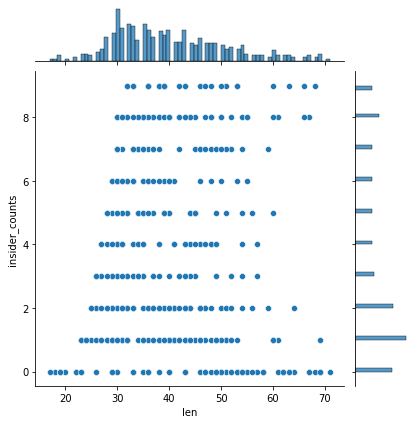

In [ ]:
_ = ins_dist(df_aug, True)

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;seq_len ~ U[40, 50)&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;seq_len ~ U[30, 60)

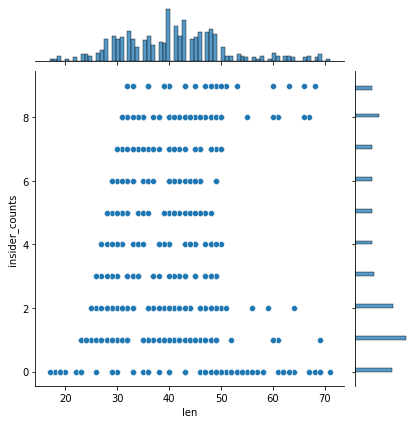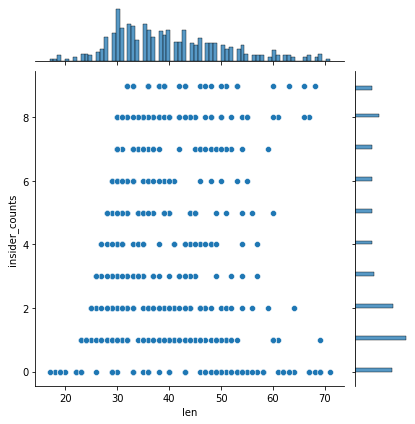

before

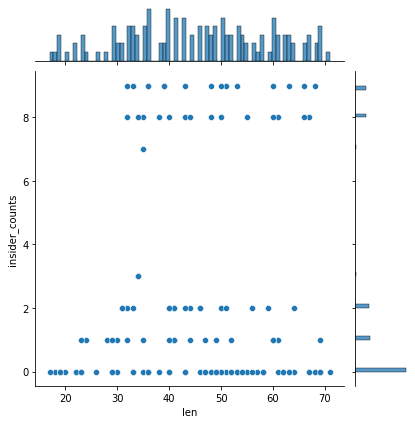

In [ ]:
df = pd.read_csv('data/data_1.0.csv', index_col='idx')
print(len(df), 'activities', len(df['user'].unique()), 'users')
df.head()

6164 activities 136 users


,user,Factor 0,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,...,Factor 171,Factor 172,Factor 173,Factor 174,Factor 175,Factor 176,Factor 177,Factor 178,Factor 179,insider
idx,,,,,,,,,,,,,,,,,,,,,
4,4,-4.161102,1.560044,-8.124948,0.467998,1.072310,-0.006214,0.899081,-1.062198,1.233125,...,-0.032603,0.006035,0.034914,-0.010609,0.079723,0.038385,0.193146,0.062444,-0.292322,0
11,11,-2.305500,0.250883,4.365914,4.736438,0.584315,-0.197276,-1.674050,-0.595670,0.674753,...,-0.017641,-0.003251,0.000009,-0.032265,0.037638,0.026005,0.053618,0.022785,0.023486,0
14,14,-2.181643,0.481197,3.060185,2.956854,2.189645,-0.152925,2.020173,-1.399258,1.919320,...,-0.014198,0.036104,0.001630,0.006455,0.012434,0.005283,0.042302,0.046378,-0.054852,0
19,19,13.541925,-24.209347,2.363907,0.518283,6.316195,-1.686172,7.008737,6.616558,-10.033314,...,0.259808,-0.550333,0.146239,-0.040161,-0.070022,0.012893,0.110709,-0.105692,0.009383,0
26,26,-2.959503,-0.201772,2.386731,3.505731,-1.527463,-0.075507,-1.938480,0.108575,0.026511,...,0.002487,0.040563,-0.021064,0.019389,-0.019802,-0.033703,-0.147209,0.006421,0.075799,0


In [ ]:
df_augmentated = pd.merge(df_aug[['user']], df.iloc[:,1:], how = 'left', left_index = True, right_index = True)
df_augmentated.to_csv('data/data_2.1.csv', index='idx')

In [ ]:
pd.read_csv('data/data_2.0.csv', index_col='idx')

,user,Factor 0,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,...,Factor 171,Factor 172,Factor 173,Factor 174,Factor 175,Factor 176,Factor 177,Factor 178,Factor 179,insider
idx,,,,,,,,,,,,,,,,,,,,,
4,4.0,-4.161102,1.560044,-8.124948,0.467998,1.072310,-0.006214,0.899081,-1.062198,1.233125,...,-0.032603,0.006035,0.034914,-0.010609,0.079723,0.038385,0.193146,0.062444,-0.292322,0
11,11.0,-2.305500,0.250883,4.365914,4.736438,0.584315,-0.197276,-1.674050,-0.595670,0.674753,...,-0.017641,-0.003251,0.000009,-0.032265,0.037638,0.026005,0.053618,0.022785,0.023486,0
14,14.0,-2.181643,0.481197,3.060185,2.956854,2.189645,-0.152925,2.020173,-1.399258,1.919320,...,-0.014198,0.036104,0.001630,0.006455,0.012434,0.005283,0.042302,0.046378,-0.054852,0
19,19.0,13.541925,-24.209347,2.363907,0.518283,6.316195,-1.686172,7.008737,6.616558,-10.033314,...,0.259808,-0.550333,0.146239,-0.040161,-0.070022,0.012893,0.110709,-0.105692,0.009383,0
26,26.0,-2.959503,-0.201772,2.386731,3.505731,-1.527463,-0.075507,-1.938480,0.108575,0.026511,...,0.002487,0.040563,-0.021064,0.019389,-0.019802,-0.033703,-0.147209,0.006421,0.075799,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63995,260.0,-3.669731,0.854492,-3.030011,0.111604,-0.007777,0.178898,-5.602695,-0.242699,-0.247221,...,0.018145,-0.024822,0.020976,0.010079,-0.029098,0.001196,0.014877,0.057312,0.037050,0
64270,581.0,-2.567785,-1.013967,6.487972,2.916666,-2.220128,0.025930,-6.162027,0.313208,-0.360649,...,-0.000348,-0.002359,0.006970,0.007919,0.011397,0.002849,0.020377,0.004201,-0.032087,0
64628,999.0,-2.883674,-0.046976,1.384267,-0.409838,0.057117,-0.045571,-2.048103,-0.205291,0.200650,...,-0.006209,0.023954,-0.009232,0.006867,-0.013855,0.012166,0.042800,0.014984,-0.019330,0


In [ ]:
pd.read_csv('data/data_2.1.csv', index_col='idx')

,user,Factor 0,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,...,Factor 171,Factor 172,Factor 173,Factor 174,Factor 175,Factor 176,Factor 177,Factor 178,Factor 179,insider
idx,,,,,,,,,,,,,,,,,,,,,
4,4.0,-4.161102,1.560044,-8.124948,0.467998,1.072310,-0.006214,0.899081,-1.062198,1.233125,...,-0.032603,0.006035,0.034914,-0.010609,0.079723,0.038385,0.193146,0.062444,-0.292322,0
11,11.0,-2.305500,0.250883,4.365914,4.736438,0.584315,-0.197276,-1.674050,-0.595670,0.674753,...,-0.017641,-0.003251,0.000009,-0.032265,0.037638,0.026005,0.053618,0.022785,0.023486,0
14,14.0,-2.181643,0.481197,3.060185,2.956854,2.189645,-0.152925,2.020173,-1.399258,1.919320,...,-0.014198,0.036104,0.001630,0.006455,0.012434,0.005283,0.042302,0.046378,-0.054852,0
19,19.0,13.541925,-24.209347,2.363907,0.518283,6.316195,-1.686172,7.008737,6.616558,-10.033314,...,0.259808,-0.550333,0.146239,-0.040161,-0.070022,0.012893,0.110709,-0.105692,0.009383,0
26,26.0,-2.959503,-0.201772,2.386731,3.505731,-1.527463,-0.075507,-1.938480,0.108575,0.026511,...,0.002487,0.040563,-0.021064,0.019389,-0.019802,-0.033703,-0.147209,0.006421,0.075799,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63995,260.0,-3.669731,0.854492,-3.030011,0.111604,-0.007777,0.178898,-5.602695,-0.242699,-0.247221,...,0.018145,-0.024822,0.020976,0.010079,-0.029098,0.001196,0.014877,0.057312,0.037050,0
64270,581.0,-2.567785,-1.013967,6.487972,2.916666,-2.220128,0.025930,-6.162027,0.313208,-0.360649,...,-0.000348,-0.002359,0.006970,0.007919,0.011397,0.002849,0.020377,0.004201,-0.032087,0
64628,999.0,-2.883674,-0.046976,1.384267,-0.409838,0.057117,-0.045571,-2.048103,-0.205291,0.200650,...,-0.006209,0.023954,-0.009232,0.006867,-0.013855,0.012166,0.042800,0.014984,-0.019330,0


# other granularity

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('../ExtractedData/weekr4.2.csv') # 67166 rows × 668 columns
df1 = pd.read_csv('../ExtractedData/dayr4.2.csv') # 330452 rows × 508 columns
df2 = pd.read_csv('../ExtractedData/sessionnact25r4.2.csv') # 1605333 rows × 129 columns
# df3 = pd.read_csv('../ExtractedData/sessionnact50r4.2.csv') # 1738761 rows × 129 columns
df4 = pd.read_csv('../ExtractedData/sessiontime120r4.2.csv') 
# df5 = pd.read_csv('../ExtractedData/sessiontime240r4.2.csv')

In [ ]:
del df3

In [ ]:
print(ins_df['insider_counts'].sum()/67166)
print(ins_df1['insider_counts'].sum()/330452)
print(ins_df2['insider_counts'].sum()/160533)
print(ins_df4['insider_counts'].sum()/1738761)

0.008784206294851563
0.005649837192693644
0.03375629932786405
0.003642823826851419


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


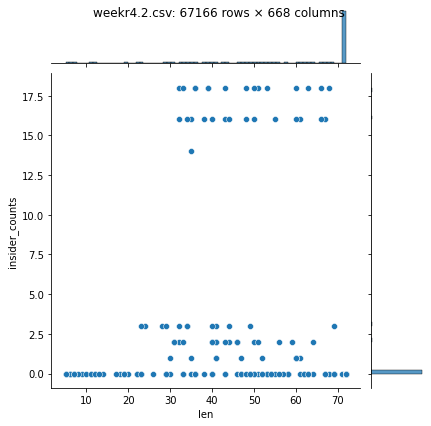

In [ ]:
ins_df = ins_dist(df)
plt.suptitle('weekr4.2.csv: 67166 rows × 668 columns')
# 845 of (72,0)
# 70 users with insider

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0.98, 'dayr4.2.csv: 330452 rows × 508 columns')

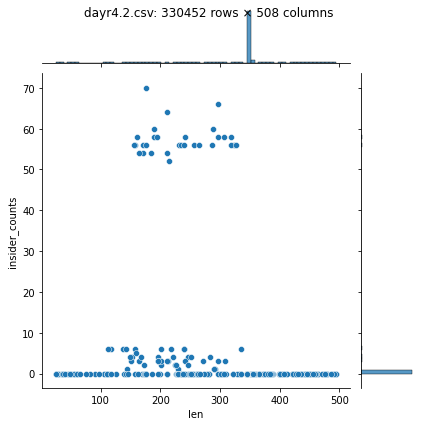

In [ ]:
ins_df1 = ins_dist(df1)
plt.suptitle('dayr4.2.csv: 330452 rows × 508 columns')
# 707 of (346,0)
# 70 users with insider

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0.98, 'sessionnact25r4.2.csv: 1605333 rows × 129 columns')

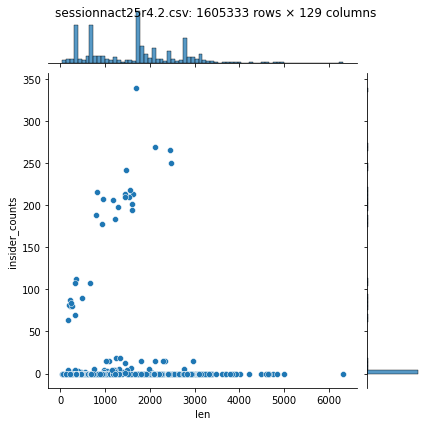

In [ ]:
ins_df2 = ins_dist(df2)
plt.suptitle('sessionnact25r4.2.csv: 1605333 rows × 129 columns')
# 70 users with insider

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0.98, 'sessiontime120r4.2.csv: 1738761 rows × 129 columns')

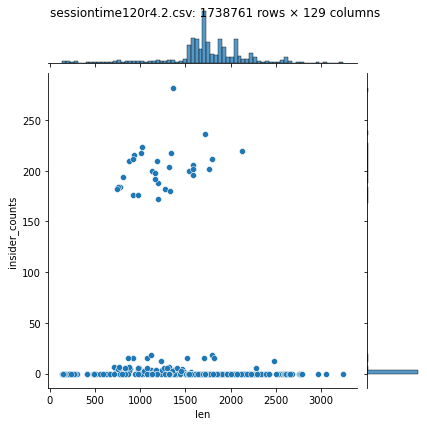

In [ ]:
ins_df4 = ins_dist(df4)
plt.suptitle('sessiontime120r4.2.csv: 1738761 rows × 129 columns')
# 70 users with insider

In [ ]:
ins_df[(ins_df['len']==72)&(ins_df['insider_counts']==0)]

,insider_counts,len
user,,
0,0,72
2,0,72
3,0,72
5,0,72
6,0,72
...,...,...
994,0,72
995,0,72
996,0,72
